In [2]:
import argparse
import os
import glob
import random
import numpy as np
import time
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
import datetime

import torchvision
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torch.nn.init as init

from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from IPython.display import display, clear_output

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from google.colab import drive
drive.mount('/content/drive')


MessageError: Error: credential propagation was unsuccessful

In [ ]:


def results_show(image1,image2,image3,ssim_scores,psnr_scores, figsize=(100,100)):
    """Permet de visualiser l'efficacité du model.

    - image 1 : image bruitée
    - image 2 : image débruitée
    - image 3 : vérité terrain"""
    psnr1,psnr2 = psnr_scores
    ssim1,ssim2 = ssim_scores

    f, (ax1, ax2, ax3) = plt.subplots(1, 3,dpi = 600)

    # Affichez chaque image sur son axe respectif
    ax1.imshow(image1)
    ax1.set_title('Image Bruitée'+'\n'+f'PSNR = {ssim1}'+'\n'+f'SSIM = {psnr1}',fontsize = 5)
    ax1.axis('off')  # Désactive les axes pour une meilleure visibilité

    ax2.imshow(image2)
    ax2.set_title('Image Débruitée'+'\n'+f'PSNR = {ssim2}'+'\n'+f'SSIM = {psnr2}',fontsize = 5)
    ax2.axis('off')

    ax3.imshow(image3)
    ax3.set_title('Vérité Terrain')
    ax3.axis('off')
    plt.show()

def log(*args, **kwargs):
    print('\r',datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S:"), *args, **kwargs)
    sys.stdout.flush()

def psnr_calcul(image1,image2):
  mse = np.mean((image1 - image2)**2)
  if mse ==0:
    return float('inf')
  max_pixel = 255.0
  psnr = 20*np.log10(max_pixel/np.sqrt(mse))
  return psnr


In [ ]:

mean = [0.4361, 0.4435, 0.4457]
std = [0.1523, 0.1478, 0.1473]

class DenoisingDataset(Dataset):
    """Dataset wrapping tensors.
    """
    def __init__(self,data_path,sigma,patch_size = 35,training = True):
        super(DenoisingDataset, self).__init__()
        self.file_list = glob.glob(data_path+'/*.png')

        self.transforms = torchvision.transforms.Compose([torchvision.transforms.Normalize(mean = mean,std = std),
                                                          torchvision.transforms.RandomResizedCrop(size =patch_size,antialias=None),
                                                          torchvision.transforms.RandomHorizontalFlip(),
                                                          torchvision.transforms.RandomVerticalFlip(),
                                                          torchvision.transforms.RandomRotation(30)
                                                          ])
        self.sigma = sigma
        self.training = training

    def __getitem__(self, index):
        batch_x = torchvision.io.read_image(self.file_list[index])
        batch_x = batch_x[0:3,:,:].float()/255.0

        if self.training : batch_x = self.transforms(batch_x)
        if self.sigma == -1 :
          self.sigma = random.randint(0,50)
          #print(self.sigma)
        noise = torch.randn(batch_x.size()).mul_(self.sigma/255.0)
        batch_y = batch_x + noise

        return batch_y, batch_x, noise

    def __len__(self):
        return len(self.file_list)


class PersonalDenoiserFataset(Dataset):
    """Dataset pour débruiter des images déjà bruitée. Seulement utile pour une mise en application.
    """
    def __init__(self,data_path):
        super(PersonalDenoiserFataset, self).__init__()
        self.file_list = self.file_list = glob.glob(data_path+'/*.png')

    def __getitem__(self, index):
        batch_x = torchvision.io.read_image(self.file_list[index])
        batch_x = batch_x.float()/255.0

        return batch_x

    def __len__(self):
        return len(self.file_list)


##Va falloir essayer de comprendre les paramètres genre momentum ?
class DnCNN(nn.Module):
    def __init__(self, depth=7, n_channels=64, image_channels=3, use_bnorm=True, kernel_size=3):
        super(DnCNN, self).__init__()
        kernel_size = 3
        padding = 1
        layers = []

        layers.append(nn.Conv2d(in_channels=image_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=True))
        layers.append(nn.ReLU(inplace=True))
        for _ in range(depth-2):
            layers.append(nn.Conv2d(in_channels=n_channels, out_channels=n_channels, kernel_size=kernel_size, padding=padding, bias=False))
            layers.append(nn.BatchNorm2d(n_channels, eps=0.0001, momentum = 0.95))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Conv2d(in_channels=n_channels, out_channels=image_channels, kernel_size=kernel_size, padding=padding, bias=False))
        self.dncnn = nn.Sequential(*layers)
        self._initialize_weights()

    def forward(self, x):
        out = self.dncnn(x)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.orthogonal_(m.weight)
                print('init weight')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)



init weight
init weight
init weight
init weight
init weight
init weight
init weight
===> Building model
Début de l'entrainement


Progression des époques: 100%|██████████| 1000/1000 [19:07<00:00,  1.15s/it]


min_loss achieved for epoch 621


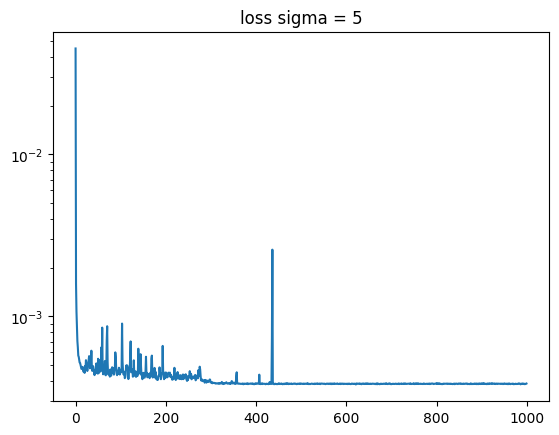

In [ ]:

parser = argparse.ArgumentParser(description='PyTorch DnCNN')
parser.add_argument('--model_name', default='model_rgb_sigma_5.pth', type=str, help="Nom du model qu'on souhaite entrainer ou tester")
parser.add_argument('--sigma', default=5, type=int, help="Choix du sigma à utliser pour ,l'entrainement et le test. Attention un sigma de -1 rendra le sigma alétoire entre 0 et 50")
parser.add_argument('--image_channels', default=3,type=int, help="permet de choisir si les images traitée sont en rgb ou en niveau de gris")



##Données d'entrainement
parser.add_argument('--train_data', default='/content/drive/My Drive/DnCNN/Data/Data_rgb/Train', type=str, help='path of train data')
#Paramètre de sauvegarde
parser.add_argument('--model_dir', default='/content/drive/My Drive/DnCNN/Models', help='directory of the model')
parser.add_argument('--loss_dir', default='/content/drive/My Drive/DnCNN/Loss', help='directory of the loss plot')
parser.add_argument('--model', default='DnCNN', type=str, help='choose a type of model')
args, unknown = parser.parse_known_args()


###Choix des hyper_paramètres
training_batch_size = 1
training_nb_epoch = 1000
training_learning_rate = 1e-3
training_patch_size = 35

training_network = DnCNN(image_channels=args.image_channels)
training_optimizer = optim.Adam(training_network.parameters(), lr=training_learning_rate)
training_criterion = F.mse_loss
training_scheduler = MultiStepLR(training_optimizer, milestones=[int(training_nb_epoch*0.8)], gamma=0.1)



def model_training(network,optimizer,criterion,scheduler,nb_epoch,patch_size,batch_size) :
    # model selection
    print('===> Building model')

    model = network
    DDataset = DenoisingDataset(data_path=args.train_data
                                    ,sigma = args.sigma,patch_size=patch_size,training=True)
    model.train()

    cuda = torch.cuda.is_available()
    torch.cuda.synchronize()
    if cuda:
        model = model.cuda()
        #criterion = criterion.cuda()

    loss_evolution =[]
    min_loss = 1
    best_model = model
    print("Début de l'entrainement")
    min_epoch = 1
    for epoch in tqdm(range(nb_epoch), desc="Progression des époques",leave=True):

        scheduler.step(epoch)  # step to the learning rate in this epcoh

        DLoader = DataLoader(dataset=DDataset,batch_size=batch_size, shuffle=True)

        epoch_loss,n_count = 0,0

        for batch_y, batch_x, noise in (DLoader):

                optimizer.zero_grad()

                if cuda:
                    batch_x, batch_y,noise = batch_x.cuda(), batch_y.cuda(),noise.cuda()

                loss = criterion(model(batch_y), noise)
                epoch_loss += loss.item()
                loss.backward()
                optimizer.step()

                n_count +=1

        epoch_loss = (epoch_loss/n_count)
        loss_evolution.append(epoch_loss)

        if epoch == 0 :
             min_loss = epoch_loss
        elif epoch_loss < min_loss :
             min_loss = epoch_loss
             min_epoch = epoch
             best_model = model
    torch.save(best_model, os.path.join(args.model_dir,args.model_name))
    print(f"min_loss achieved for epoch {min_epoch}")
    return loss_evolution

loss_evolution = model_training(network=training_network,
                                optimizer=training_optimizer,
                                criterion=training_criterion,
                                scheduler=training_scheduler,
                                nb_epoch=training_nb_epoch,
                                patch_size=training_patch_size,
                                batch_size=training_batch_size)

plt.figure()
plt.semilogy(loss_evolution)
plt.title(f'loss sigma = {args.sigma}')
plt.savefig(args.loss_dir)


In [4]:

psnr_results = {
      'whatin': 'Contient les listes des psnr obtenus pour chaque sigma',
}



parser = argparse.ArgumentParser(description='PyTorch DnCNN')
parser.add_argument('--model_name', default='model_name.pth', type=str, help="Nom du model qu'on souhaite entrainer ou tester")
parser.add_argument('--sigma', default=25, type=int, help="Choix du sigma à utliser pour ,l'entrainement et le test. Attention un sigma de -1 rendra le sigma alétoire entre 0 et 50")
parser.add_argument('--model_dir', default='path/to/model', help='directory of the model')
parser.add_argument('--test_data', default='path/to/data_tests', type=str, help='path of test data')
parser.add_argument('--result_file',default='Scores PSNR débruitage.json',type = str,help = 'name of the file containing the results of the test')
parser.add_argument('--visualisation',default=0,type=int,help="Choisi d'afficher les images débruitée ou non")
args, unknown = parser.parse_known_args()

def model_test() :

    psnr_noise_images = []
    psnr_denoise_images = []

    ssim_noise_images = []
    ssim_denoise_images = []

    denoising_time = []

    cuda = torch.cuda.is_available()
    if cuda :
        model = torch.load(os.path.join(args.model_dir,args.model_name)).cuda()
    else :

        model = torch.load(os.path.join(args.model_dir,args.model_name))

    model.eval()
    DDataset = DenoisingDataset(data_path=args.test_data
                                    ,sigma = args.sigma,training=False)
    DLoader = DataLoader(dataset=DDataset,batch_size=1, shuffle=True)

    with torch.no_grad():
        for batch_y, batch_x, noise in tqdm(DLoader,f" Chargement des images sig = {args.sigma}"):

            if cuda :
                torch.cuda.synchronize()
                batch_x, batch_y,noise = batch_x.cuda(), batch_y.cuda(), noise.cuda()

            start_time = time.time()
            batch_predicted = model(batch_y)
            elapsed_time = time.time() - start_time
            denoising_time.append(elapsed_time)

            batch_predicted = batch_y - batch_predicted

            batch_x = batch_x.squeeze(0).permute(1, 2, 0)
            batch_x = batch_x.cpu()
            batch_x = batch_x.detach().numpy().astype(np.float32)

            batch_y = batch_y.squeeze(0).permute(1, 2, 0)
            batch_y = batch_y.cpu()
            batch_y = batch_y.detach().numpy().astype(np.float32)

            batch_predicted = batch_predicted.squeeze(0).permute(1, 2, 0)
            batch_predicted = batch_predicted.cpu()
            batch_predicted = batch_predicted.detach().numpy().astype(np.float32)

            psnr_noise = psnr(batch_x,batch_y,data_range = 1.0)
            psnr_denoise = psnr(batch_x,batch_predicted,data_range = 1.0)

            psnr_noise_images.append(psnr_noise)
            psnr_denoise_images.append(psnr_denoise)

            ssim_index_noise,_ = ssim(batch_x,batch_y,channel_axis = -1,full=True)
            ssim_index_denoise,_ = ssim(batch_x,batch_predicted,channel_axis = -1,full=True)

            ssim_noise_images.append(float(ssim_index_noise))
            ssim_denoise_images.append(float(ssim_index_denoise))

            if args.visualisation :
                results_show(image1=batch_x,image2=batch_predicted,image3=batch_y,
                            psnr_scores=(psnr_noise,psnr_denoise),
                            ssim_scores=(1,1))

    name_d_psnr_1 = str(args.sigma) + '_d_psnr_1'
    name_b_psnr_1 = str(args.sigma) + '_b_psnr_1'

    name_d_ssim = str(args.sigma) + '_d_ssim'
    name_b_ssim = str(args.sigma) + '_b_ssim'

    name_t = str(args.sigma) + '_t'
    psnr_results[name_b_psnr_1] = psnr_noise_images
    psnr_results[name_d_psnr_1] = psnr_denoise_images

    psnr_results[name_b_ssim] = ssim_noise_images
    psnr_results[name_d_ssim] = ssim_denoise_images

    psnr_results[name_t] = denoising_time
    return

model_test()

with open(args.result_file, 'w') as fichier:
        json.dump(psnr_results, fichier)



0


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/DnCNN/Models/finales_models/model_rgb_sigma_1-50.pth'